## Imports

In [1]:
import optuna
import pandas as pd
from networkx.classes import non_neighbors
from optuna import trial

# Data Set
from sklearn.datasets import fetch_california_housing

# Data Management, metrics and model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



#Plots
import matplotlib.pyplot as plt

#Other
import  numpy as np
import pandas as pd

## Data and Data Split

In [2]:
seed = 42
data = fetch_california_housing()

x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=seed)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)


# Data standardization
scaler = StandardScaler()
x_train, y_train =scaler.fit(x_train).transform(x_train), scaler.fit(y_train).transform(y_train).ravel()
x_test, y_test =  scaler.fit(x_test).transform(x_test), scaler.fit(y_test).transform(y_test).ravel()

## Metrics Calculator

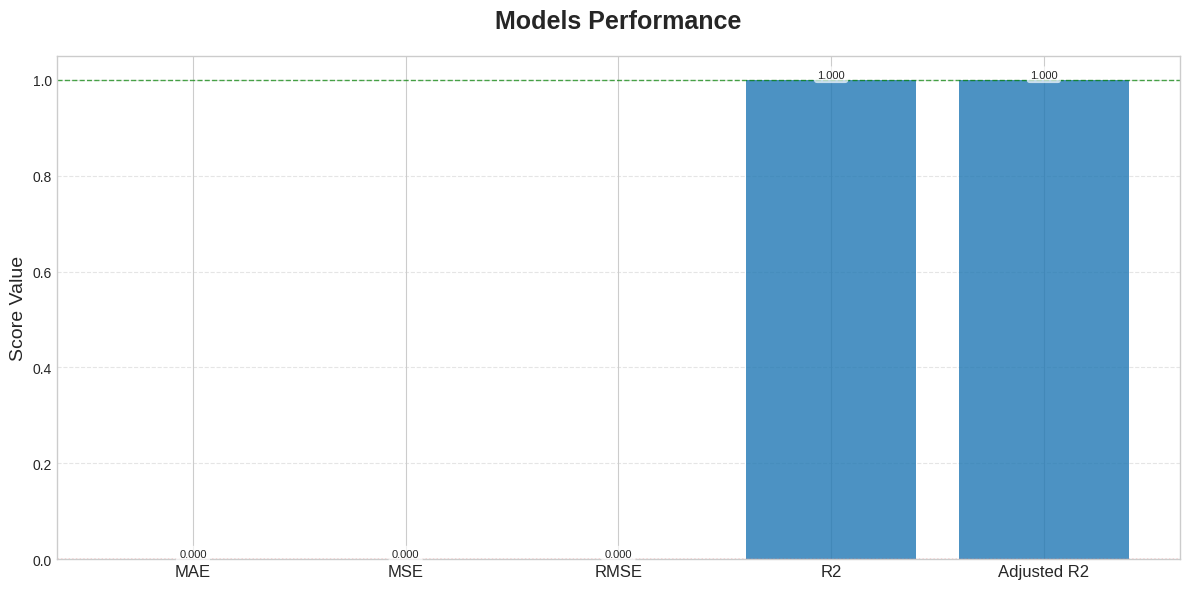

,Metric,Value
0,MAE,0.0
1,MSE,0.0
2,RMSE,0.0
3,R2,1.0
4,Adjusted R2,1.0


In [3]:
def metric(y_hat, y_true,features_shape):
    n,p = features_shape
    r2 = r2_score(y_true, y_hat)
    socres = {
        "MAE": mean_absolute_error(y_true, y_hat),
        "MSE": mean_squared_error(y_true, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "R2": r2,
        "Adjusted R2":  1 - (1 - r2) * (n - 1) / (n - p - 1)
    }

    df_score = pd.DataFrame(socres.items(), columns=["Metric","Value"])

    return df_score


dummy  = metric(y_test, y_test, x_train.shape)

def plot_meterics(df_dict):

    if isinstance(df_dict, pd.DataFrame):
        df_dict = {'Model': df_dict}

    # Define the order and subset of metrics to plot
    metrics_to_plot = ["MAE", "MSE", "RMSE", "R2", "Adjusted R2"]
    metrics_order = {m: i for i, m in enumerate(metrics_to_plot)}

    # Combine and filter dataframes
    all_data = []
    for model_name, df in df_dict.items():
        # Filter for the required metrics
        filtered_df = df[df['Metric'].isin(metrics_to_plot)].copy()
        filtered_df['Model'] = model_name
        all_data.append(filtered_df)

    if not all_data:
        print("Error: No data available to plot after filtering.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)

    # Sort the dataframe according to the predefined metric order
    combined_df['Order'] = combined_df['Metric'].map(metrics_order)
    combined_df.sort_values(by=['Order', 'Model'], inplace=True)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    models = combined_df['Model'].unique()
    n_models = len(models)
    n_metrics = len(metrics_to_plot)
    bar_width = 0.8 / n_models

    x_base = np.arange(n_metrics)

    for i, model in enumerate(models):
        model_data = combined_df[combined_df['Model'] == model]
        values = model_data['Value'].values

        # Calculate position for this model's bars
        offset = (i - (n_models - 1) / 2) * bar_width
        bars = ax.bar(x_base + offset, values, bar_width, label=model, alpha=0.8)

        # Add value labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))


    # Customizing the plot
    ax.set_xticks(x_base)
    ax.set_xticklabels(metrics_to_plot, fontsize=12, fontweight='medium')
    ax.set_ylabel('Score Value', fontsize=14)
    ax.set_title("Models Performance", fontsize=18, fontweight='bold', pad=20)

    # Add legend if needed
    if n_models > 1 or models[0] != 'Model':
        ax.legend(title='Model', fontsize=10, title_fontsize=12, frameon=True, shadow=True)

    # Add horizontal lines for R2/Adj R2 targets for context
    ax.axhline(1.0, color='green', linestyle='--', linewidth=1.0, alpha=0.7, label='Perfect Fit (R2=1.0)')
    ax.axhline(0.0, color='red', linestyle=':', linewidth=1.0, alpha=0.7, label='Baseline Fit (R2=0.0)')

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_meterics(dummy)
dummy

# Regression Models without optimalization

In [5]:
def train_and_judge(model, x_train, y_train, x_test, y_test):
    model = model
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    features_shape = x_train.shape
    df_train = metric(y_hat_train, y_train, features_shape)

    features_shape = x_test.shape
    df_test = metric(y_hat_test, y_test, features_shape)

    print("Training Scores")
    print(df_train)
    print()
    print("Testing Scores")
    print(df_test)

    return df_test

model_performence = {}

## KNN Regresor

In [6]:
model_performence["KNN"] = train_and_judge(KNeighborsRegressor(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.307235
1          MSE  0.203102
2         RMSE  0.450668
3           R2  0.796898
4  Adjusted R2  0.796800

Testing Scores
        Metric     Value
0          MAE  0.375238
1          MSE  0.306766
2         RMSE  0.553864
3           R2  0.693234
4  Adjusted R2  0.692639


## SVE

In [7]:
model_performence["SVR"] = train_and_judge(SVR(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.329964
1          MSE  0.248902
2         RMSE  0.498901
3           R2  0.751098
4  Adjusted R2  0.750977

Testing Scores
        Metric     Value
0          MAE  0.650450
1          MSE  0.714309
2         RMSE  0.845168
3           R2  0.285691
4  Adjusted R2  0.284304


## Random Forest

In [8]:
model_performence["RF"] = train_and_judge(RandomForestRegressor(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.104937
1          MSE  0.026459
2         RMSE  0.162661
3           R2  0.973541
4  Adjusted R2  0.973529

Testing Scores
        Metric     Value
0          MAE  0.482813
1          MSE  0.462944
2         RMSE  0.680400
3           R2  0.537056
4  Adjusted R2  0.536157


## Extreme Gradient Boosting Regressor

In [9]:
model_performence["XGB"] = train_and_judge(XGBRegressor(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.166561
1          MSE  0.055427
2         RMSE  0.235430
3           R2  0.944573
4  Adjusted R2  0.944546

Testing Scores
        Metric     Value
0          MAE  0.464387
1          MSE  0.423654
2         RMSE  0.650887
3           R2  0.576346
4  Adjusted R2  0.575523


## Model performance on test data


        Metric     Value
0          MAE  0.375238
1          MSE  0.306766
2         RMSE  0.553864
3           R2  0.693234
4  Adjusted R2  0.692639


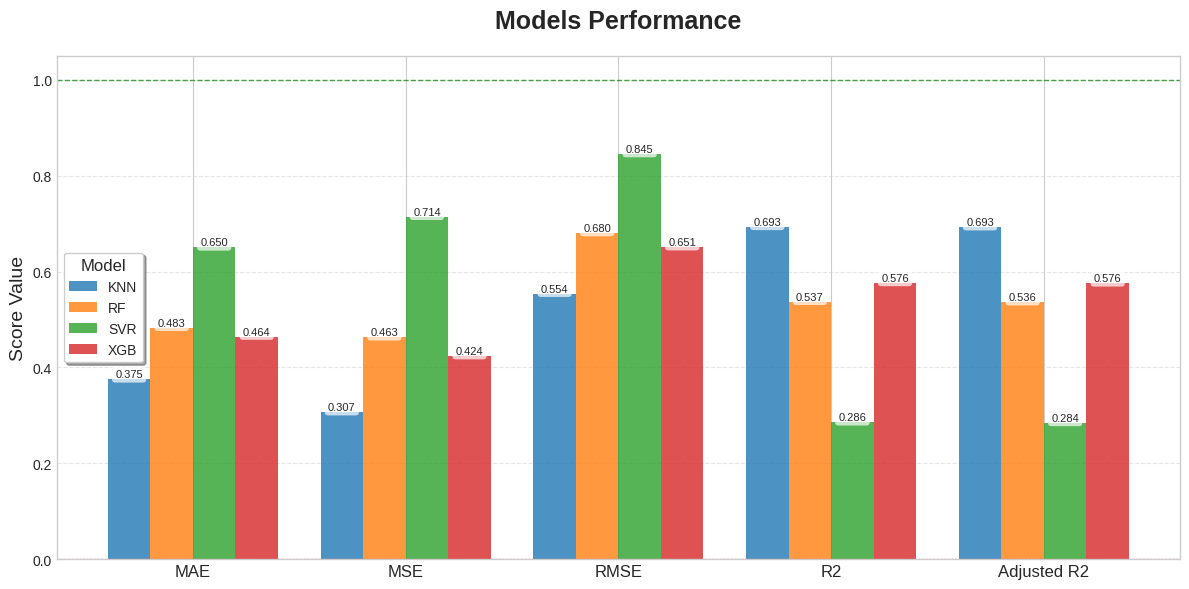

In [10]:
print(model_performence['KNN'])
plot_meterics(model_performence)


# Model with optimalization

In [4]:
def optimize_train_and_judge(model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)

    model = model_class(**study.best_params)
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    features_shape = x_train.shape
    df_train = metric(y_hat_train, y_train, features_shape)

    features_shape = x_test.shape
    df_test = metric(y_hat_test, y_test, features_shape)

    print("Training Scores")
    print(df_train)
    print()
    print("Testing Scores")
    print(df_test)

    return df_test

model_performence = {}

## KNN Regresor

In [12]:
def KNN_objective(trail):
    n_neighbors = trail.suggest_int("n_neighbors", 1, 80)
    weights = trail.suggest_categorical('weights', ['uniform', 'distance'])
    metric  = trail.suggest_categorical('metric', ['manhattan', 'euclidean','minkowski'])

    clf = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score


model_performence['KNN'] = optimize_train_and_judge(KNeighborsRegressor, KNN_objective)

[I 2025-11-16 15:36:16,262] A new study created in memory with name: no-name-7cf65e61-f9c9-4efb-8275-35977314f448


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 15:36:17,292] Trial 0 finished with value: -0.3086820573070797 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: -0.3086820573070797.
[I 2025-11-16 15:36:18,697] Trial 1 finished with value: -0.3410495006429537 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.3086820573070797.
[I 2025-11-16 15:36:19,446] Trial 2 finished with value: -0.30860374645010624 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 2 with value: -0.30860374645010624.
[I 2025-11-16 15:36:20,565] Trial 3 finished with value: -0.31868028976426255 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: -0.30860374645010624.
[I 2025-11-16 15:36:22,782] Trial 4 finished with value: -0.29960572298274063 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'manhattan'}. B

## SVR

In [ ]:
def SVR_study(trial):
    C = trial.suggest_float("C", 0.01, 1)
    epsilon = trial.suggest_float("epsilon", 0.001, 0.01)
    kernel = trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float("gamma", 0.1, 1)


    clf = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

model_performence['SVR'] = optimize_train_and_judge(SVR, SVR_study, trails=5)

[I 2025-11-16 15:38:43,197] A new study created in memory with name: no-name-7aff6e57-9ea0-4bae-87dc-0605af5a586d


  0%|          | 0/10 [00:00<?, ?it/s]

## Random Forest

In [10]:
def RF_study(trail):

    n_estimators = trail.suggest_int("n_estimators", 75, 125)
    max_depth = trail.suggest_int("max_depth", 2, 10)
    min_samples_split = trail.suggest_int("min_samples_split", 2, 10)
    max_features = trail.suggest_categorical("max_features", ["sqrt", 'log2', 1.0])

    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features ,random_state=42)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

model_performence['RF'] = optimize_train_and_judge(RandomForestRegressor, RF_study)

[I 2025-11-16 13:44:48,421] A new study created in memory with name: no-name-716843b4-3a77-4738-af1c-ca37fd86b593


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 13:45:05,265] Trial 0 finished with value: -0.2702876046284081 and parameters: {'n_estimators': 79, 'max_depth': 7, 'min_samples_split': 7, 'max_features': 1.0}. Best is trial 0 with value: -0.2702876046284081.
[I 2025-11-16 13:45:10,232] Trial 1 finished with value: -0.36863222678396135 and parameters: {'n_estimators': 111, 'max_depth': 5, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: -0.2702876046284081.
[I 2025-11-16 13:45:23,543] Trial 2 finished with value: -0.3828512601395855 and parameters: {'n_estimators': 107, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 1.0}. Best is trial 0 with value: -0.2702876046284081.
[I 2025-11-16 13:45:31,228] Trial 3 finished with value: -0.26568844770579364 and parameters: {'n_estimators': 88, 'max_depth': 7, 'min_samples_split': 5, 'max_features': 'log2'}. Best is trial 3 with value: -0.26568844770579364.
[I 2025-11-16 13:45:55,424] Trial 4 finished with value: -0.23029569946930395 and paramet

## XGBoost


In [5]:
def XGBoost_study(trail):
    n_estimators = trail.suggest_int("n_estimators", 75, 125)
    max_depth = trail.suggest_int("max_depth", 2, 10)
    learning_rate = trail.suggest_float("learning_rate", 0.01, 0.05)
    subsample = trail.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trail.suggest_float("colsample_bytree", 0.1, 1.0)

    clf = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

model_performence['XGB'] = optimize_train_and_judge(XGBRegressor, XGBoost_study)


[I 2025-11-16 17:49:26,735] A new study created in memory with name: no-name-b8073143-a1ed-4b67-b74f-baa94d8f13cc


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 17:49:29,268] Trial 0 finished with value: -0.18572246433685088 and parameters: {'n_estimators': 88, 'max_depth': 8, 'learning_rate': 0.038963917257528784, 'subsample': 0.3981011589605533, 'colsample_bytree': 0.8969749444490556}. Best is trial 0 with value: -0.18572246433685088.
[I 2025-11-16 17:49:30,626] Trial 1 finished with value: -0.3162542592631363 and parameters: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.031067115148872226, 'subsample': 0.4660805922532284, 'colsample_bytree': 0.3035852837910234}. Best is trial 0 with value: -0.18572246433685088.
[I 2025-11-16 17:49:31,088] Trial 2 finished with value: -0.49016253440258434 and parameters: {'n_estimators': 95, 'max_depth': 6, 'learning_rate': 0.038552338076242545, 'subsample': 0.8101603962328001, 'colsample_bytree': 0.22459156993178786}. Best is trial 0 with value: -0.18572246433685088.
[I 2025-11-16 17:49:31,333] Trial 3 finished with value: -0.3771313744275331 and parameters: {'n_estimators': 117, 'm

In [ ]:
plot_meterics(model_performence)